### Multinomial Regression

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import time

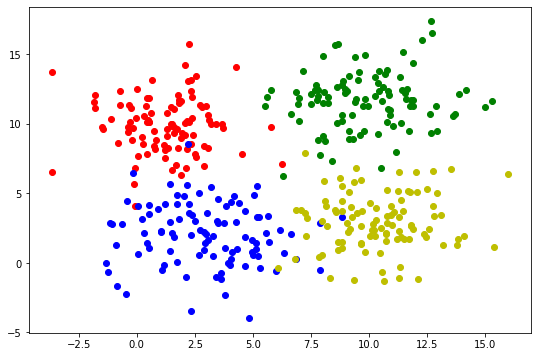

In [2]:
# Synthetic data
mu_1 = np.array([1,10])
mu_2 = np.array([10,12])
mu_3 = np.array([3,2])
mu_4 = np.array([10,3])
sigma = np.array([[4,0],[0,4]])

X1 = np.random.multivariate_normal(mu_1,sigma,100)
X2 = np.random.multivariate_normal(mu_2,sigma,100)
X3 = np.random.multivariate_normal(mu_3,sigma,100)
X4 = np.random.multivariate_normal(mu_4,sigma,100)

plt.figure(figsize=(9,6))
plt.plot(X1[:,0],X1[:,1],'ro')
plt.plot(X2[:,0],X2[:,1],'go')
plt.plot(X3[:,0],X3[:,1],'bo')
plt.plot(X4[:,0],X4[:,1],'yo')
plt.show()

In multinomial regression, we have $K$ classes and inputs with $n$ features, i.e., $\mathcal{X} = \mathbb{R}^n$ and $\mathcal{Y} = \{ 1, \ldots, m \}$

$$\mathcal{X} = 
\begin{bmatrix} 
1 & x_{1}^{1} & x_{1}^{2}& .. & x_{1}^{n} \\ 
1 &x_{2}^{1} & x_{2}^{2}& .. & x_{2}^{n} \\ 
: & : & : & .. & : \\
1 & x_{m}^{1} & x_{m}^{2}& .. & x_{m}^{n} \\
\end{bmatrix};
\mathcal{Y} = 
\begin{bmatrix}
y_{1} \\
y_{2} \\
: \\
y_{m} \\
\end{bmatrix} 
$$

In [3]:
X = np.concatenate((np.ones((400,1)),np.concatenate((X1,X2,X3,X4))),1)

# numpy.full(shape, fill_value, dtype=None, order='C', *, like=None)
y = np.concatenate((np.zeros((X1.shape[0],1)),
                    np.ones((X2.shape[0],1)),
                    np.full((X3.shape[0],1),2,np.float32),
                    np.full((X4.shape[0],1),3,np.float32)),0)
K = len(np.unique(y))

In [33]:
X.shape, X[:5,:]

((400, 3),
 array([[ 1.        ,  3.09234155, 10.28710315],
        [ 1.        ,  5.77470955,  9.75643653],
        [ 1.        ,  1.47524154,  9.96938363],
        [ 1.        ,  2.35965185, 11.96997535],
        [ 1.        ,  0.2675518 ,  8.5844225 ]]))

In [34]:
y.shape, y[:5]

((400, 1),
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.]]))

**Multinomial regression algorithm**

1. Data are pairs $\mathbf{x}^{(i)}, y^{(i)}$ with $\mathbf{x}^{(i)} \in \mathbb{R}^n$ and
   $y \in 1..K$

2. The hypothesis, for class $k$, is the estimated probability $\phi_k$ that $\mathbf{x}$ was drawn from class $k$ using the linear transformation of the input followed by the softmax function (*The hypothesis is a vector-valued function*):

$$\mathbf{h}_\theta(\mathbf{x}) = \begin{bmatrix} p(y = 1 \mid \mathbf{x} ; \theta) \\
                                         p(y = 2 \mid \mathbf{x} ; \theta) \\
                                         \vdots \\
                                         p(y = K \mid \mathbf{x} ; \theta) \end{bmatrix},$$
    where $$p(y = i \mid \mathbf{x}) = \phi_i = p(y = i \mid \mathbf{x}; \theta) = \frac{e^{\theta^\top_i \mathbf{x}}}{\sum_{j=1}^{K}e^{\theta^\top_j \mathbf{x}}}. $$

3. The cost function is the *cross entropy* loss function
   $$J(\theta) = - \sum_{i=1}^m \log p(y^{(i)} \mid \textbf{x}^{(i)})$$

4. The optimization algorithm is gradient descent on $J(\theta)$ with the update rule
   $$\theta_{kl}^{(n+1)} \leftarrow \theta_{kl}^{(n)} - \alpha \sum_{i=1}^m (\delta(y^{(i)}=k) - \phi_k) x^{(i)}_l.$$

The softmax refers to the idea that we
would like to find the maximum output of a linear transformation of the inputs, but keep the information
about the relative contribution of the $K$ different outputs.

The softmax function, for a vector of activations $\mathbf{a}$, is defined as
$$\phi_k = \frac{e^{a_k}}{\sum_{j=1}^K e^{a_j}}$$

**Multinomial Regression function**

In [4]:
# Multinomial Regression function

def hypothesis(X,theta):
    K = theta.shape[0]
    m = X.shape[0]
    a = np.zeros((m,K)) # vector of activation
    for k in range(K):
        a[:,k:k+1] = X @ theta[k:k+1,:].T
    e_a = np.exp(a)
    return e_a/e_a.sum(axis=1,keepdims=True)

def onehot(y,K):
    Y = np.zeros((y.shape[0],K))
    for k in range(K):
        Y[y.reshape(-1)==k,k]=1
    return Y

def cost(X,y,theta):
    K = theta.shape[0]
    m = X.shape[0]
    y_hat = hypothesis(X,theta)
    
    # Form the matrix delta(y=k)
    Y = onehot(y,K) 
    J = 0
    for k in range(K):
        J = J - np.log(y_hat[y.reshape(-1)==k,k]).sum()
    J = J/m
    
    # Get the gradient matrix for theta
    grad_J = (y_hat - Y).T@X
    return J, grad_J

def multi_reg(X , y , epochs, lr):
    theta = np.zeros((K,X.shape[1]))
    costs = []
    for epoch in tqdm(range(epochs),desc='Progess Bar'):
        time.sleep(0)
        J, grad_J = cost(X,y,theta)
        costs.append(J)
        theta = theta - lr*grad_J
    return theta, costs
        
def predict (X,theta):
    pred = hypothesis(X,theta)
    pred_class = np.argmax(pred,axis=1)
    return pred_class
    
def accuracy(X,y,theta):
    pred = hypothesis(X,theta)
    pred_class = np.argmax(pred,axis=1)
    acc = (pred_class==y.reshape(-1)).sum()/X.shape[0]
    return acc*100

Progess Bar:   0%|          | 0/10000 [00:00<?, ?it/s]

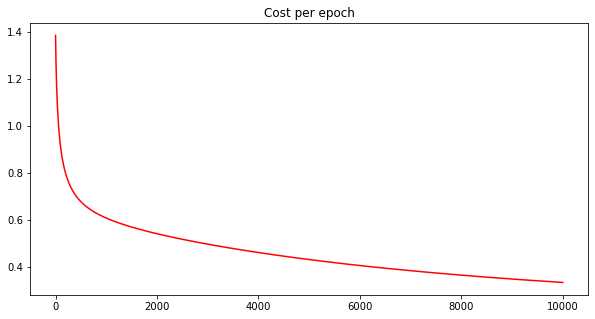

In [5]:
# Training loop
theta,costs = multi_reg(X,y,epochs=10000,lr=0.000005)

plt.figure(figsize=(10,5))
plt.title('Cost per epoch')
plt.plot(np.arange(10000),costs,'r-')
plt.show()

In [6]:
# Caculate training accuracy
accuracy = accuracy(X,y,theta)
print('Training accuracy:',accuracy,'%')

Training accuracy: 90.5 %


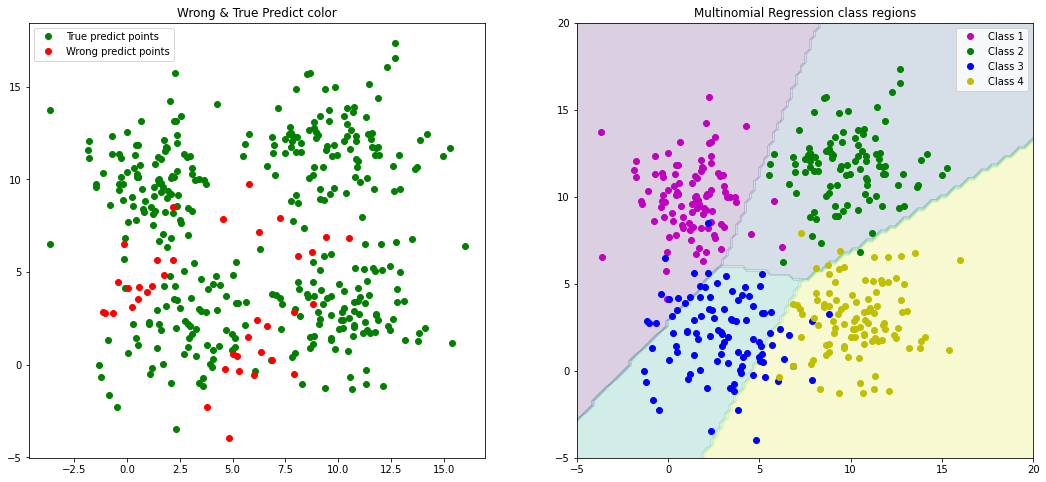

In [32]:
# Plot result
matplotlib.rcParams['figure.figsize']=[18,8]
fig,(ax1,ax2) = plt.subplots(1,2)

# color points
pred = predict(X,theta)
ax1.plot(X[pred==y.reshape(-1),1],X[pred==y.reshape(-1),2],'go',label='True predict points')
ax1.plot(X[pred!=y.reshape(-1),1],X[pred!=y.reshape(-1),2],'ro',label='Wrong predict points')
ax1.legend()
ax1.set_title('Wrong & True Predict color')

# color regions
grid_x , grid_y = np.mgrid[-5:20:100j,-5:20:100j]
grid_xy = np.concatenate((np.ones((grid_x.shape[0]**2,1)),np.vstack([grid_x.ravel(),grid_y.ravel()]).T),1)
z = predict(grid_xy,theta).reshape((100,100))
ax2.contourf(grid_x , grid_y, z, alpha = 0.2)
ax2.plot(X[y.reshape(-1)==0,1],X[y.reshape(-1)==0,2],'mo',label='Class 1')
ax2.plot(X[y.reshape(-1)==1,1],X[y.reshape(-1)==1,2],'go',label='Class 2')
ax2.plot(X[y.reshape(-1)==2,1],X[y.reshape(-1)==2,2],'bo',label='Class 3')
ax2.plot(X[y.reshape(-1)==3,1],X[y.reshape(-1)==3,2],'yo',label='Class 4')
ax2.legend()
ax2.set_title('Multinomial Regression class regions')
plt.show()